# Validation of HMASR with snow depth stations

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)
- snow depth stations: [Observational snow depth dataset of the Tibetan Plateau (Version 1.0) (1961-2013)](https://data.tpdc.ac.cn/en/data/72d6dadf-8e1c-458b-b24e-91539042dfe6/)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load topography

In [2]:
latlim = slice(27, 45)
lonlim = slice(60, 105)

ds = xr.open_dataset('../data/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load stations

In [3]:
path = '../data/in-situ_SD_TP_v1.0_1961-2013/'

df_loc = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013.txt', delimiter='\t')
df_loc.set_index('numb', inplace=True)
df_loc

,prov,name_en,name_cn,latit,longit,elevat
numb,,,,,,
52787,甘肃,S52787,乌鞘岭,37.200000,102.866667,3045.1
52978,甘肃,S52978,夏河,35.200000,102.516667,2929.4
56071,甘肃,S56071,碌曲,34.583333,102.500000,3105.7
56074,甘肃,S56074,玛曲,34.000000,102.083333,3471.4
56080,甘肃,S56080,合作,35.000000,102.900000,2910.0
...,...,...,...,...,...,...
56434,西藏,S56434,察隅,28.650000,97.466667,2327.6
56444,云南,S56444,德钦,28.483333,98.916667,3319.0
56533,云南,S56533,贡山,27.750000,98.666667,1583.3


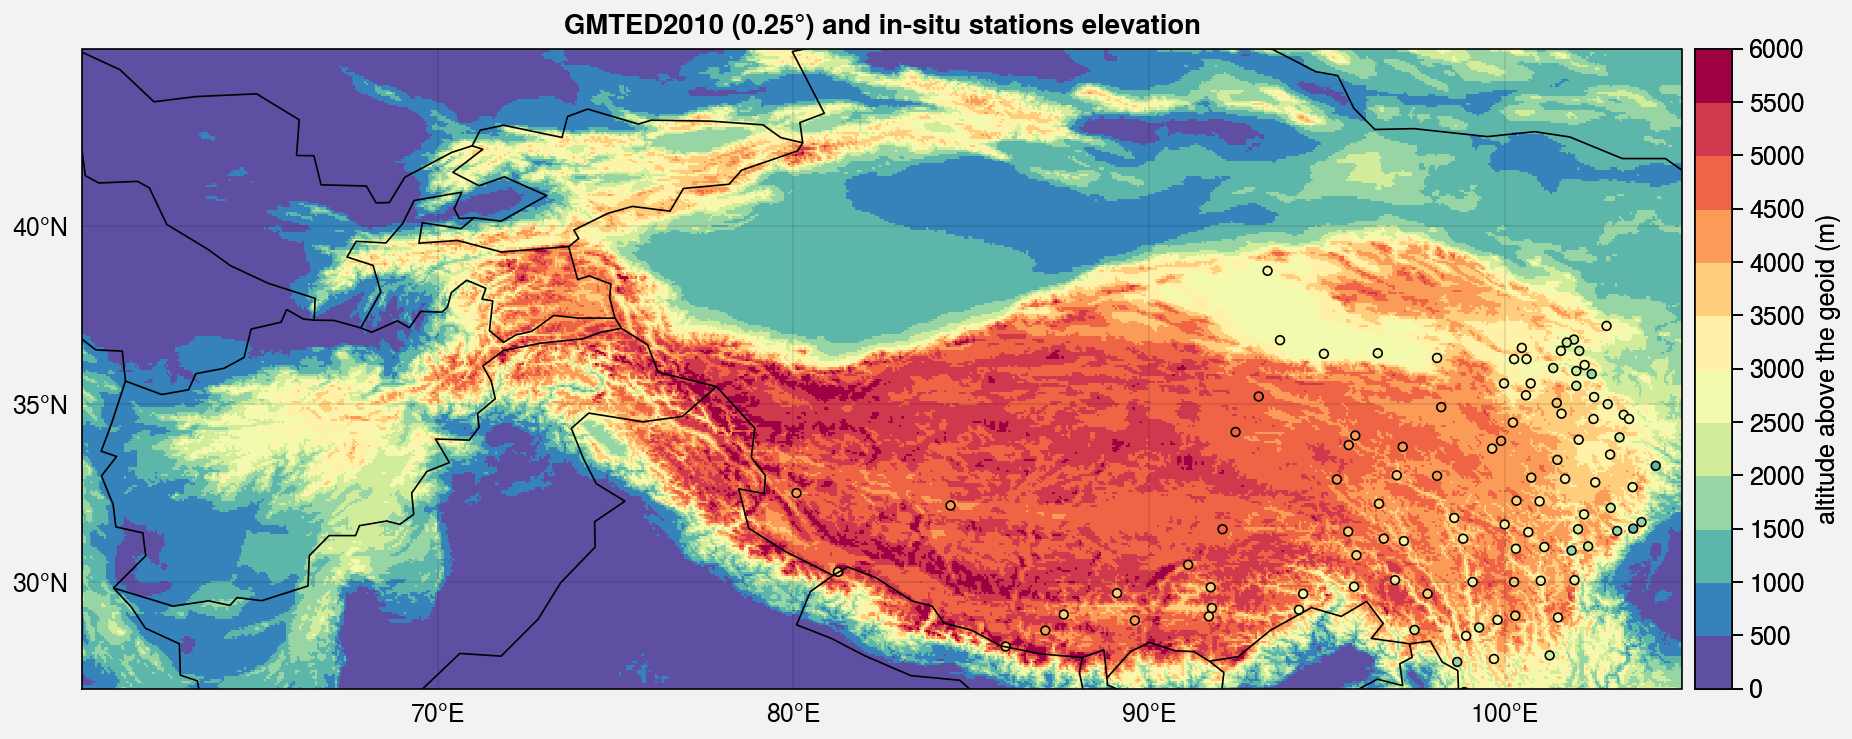

In [23]:
cmap='Spectral_r'
levels=plot.arange(0,6000,500)

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=8)

axs[0].pcolormesh(elevation, colorbar='r', cmap=cmap, levels=levels)
axs[0].scatter(df_loc.longit, df_loc.latit, markersize=10, marker='o', color=df_loc.elevat.values, cmap=cmap, edgecolors='black', levels=levels)

axs.format(
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='GMTED2010 (0.25°) and in-situ stations elevation'
)

fig.save('img/GMTED2010_elevation_SD_station.jpg')

### Data format and description
The file name is the name of the station number, and the data format is

- Station number Year Month Day Observed snow depth (cm)
- Missing measurement: 32766 and -32766
- Blank or phenomenon not present: 32744 and -32744
- Trace/ice no record flag: 32700

In [5]:
# Make a dataframe with all stations starting from HMASR (1999-10-01)
path = '../data/in-situ_SD_TP_v1.0_1961-2013/'

for i, index in enumerate(df_loc.index):

    df = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013/'+str(index)+'.txt', delimiter='\t', header=None, 
                     names=['id', 'year', 'month', 'day', 'SD'], parse_dates= {"date" : ["year","month","day"]})
    df.set_index('date', inplace=True, verify_integrity=True)
    # Remove wrong values
    missing_values = [32766, -32766, 32744, -32744, 32700]
    df['SD'] = df['SD'].replace(missing_values, [np.nan]*len(missing_values))
    
    if i == 0:
        df_all = df['1999-10-01':].rename(columns={'SD': index}).drop(columns='id')
    else:
        df_all[index] = df['1999-10-01':].rename(columns={'SD': index}).drop(columns='id')

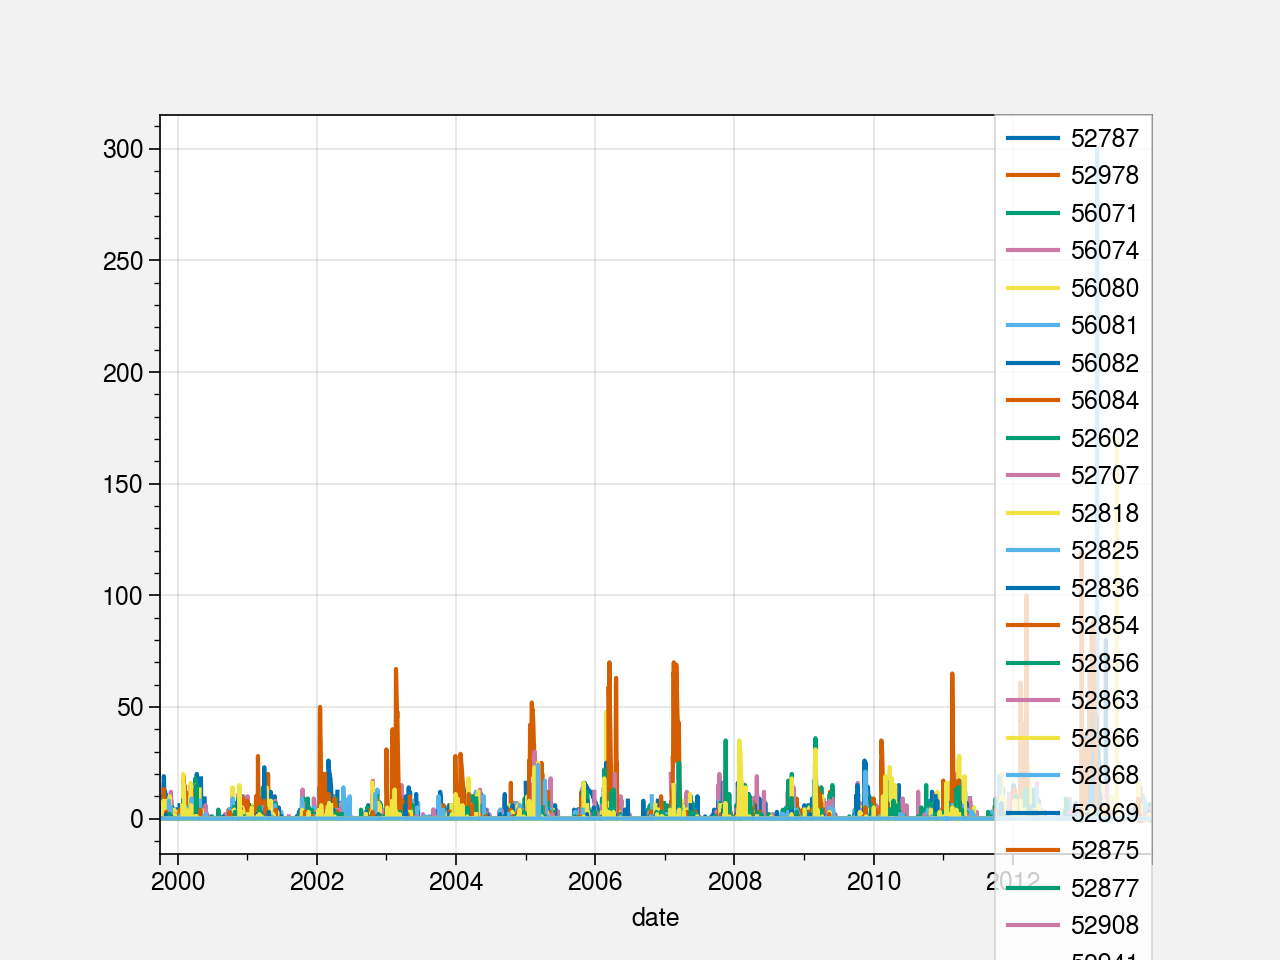

In [6]:
df_all.plot()

In [25]:
# Make a Dataframe to store both station and HMASR timeseries
iterables = [df_all.columns, ["station", "HMASR"]]
index = pd.MultiIndex.from_product(iterables, names=["numb", "product"])
df_station_HMASR = pd.DataFrame(np.nan, index=df_all.index, columns=index)
df_station_HMASR

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
1999-10-02     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
1999-10-03     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
1999-10-04     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
1999-10-05     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
2013-12-28     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
2013-12-29     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
2013-12-30     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   
2013-12-31     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN     NaN   

numb              ...   56434         56444         56533         56543        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
1999-10-02   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
1999-10-03   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
1999-10-04   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
1999-10-05   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
2013-12-28   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
2013-12-29   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
2013-12-30   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   
2013-12-31   NaN  ...     NaN   NaN     NaN   NaN     NaN   NaN     NaN   NaN   

numb         56641        
product    station HMASR  
date                      
1999-10-01     NaN   NaN  
1999-10-02     NaN   NaN  
1999-10-03     NaN   NaN  
1999-10-04     NaN   NaN  
1999-10-05     NaN   NaN  
...            ...   ...  
2013-12-27     NaN   NaN  
2013-12-28     NaN   NaN  
2013-12-29     NaN   NaN  
2013-12-30     NaN   NaN  
2013-12-31     NaN   NaN  

[5206 rows x 204 columns]

## Load HMASR corresponding to stations

### Try for one station

In [26]:

i_station = 85
lat = df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0]
lon = df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0]

list_da = []
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2014))]

for WY in WY_list:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'

    temp = xr.open_dataarray(path+'HMA_SR_D_v01_N'+str(int(lat))+'_0E'+str(int(lon))+'_0_agg_16_'+WY+'_SD_POST.nc').isel(Stats=0)
    temp = temp.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=temp.Day.size, freq='D'))
    temp = temp.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
    list_da.append(temp.sel(time=slice(df_all.index[0], df_all.index[-1])).load())
    
da = xr.concat(list_da, 'time')
da_station = da.sel(lat=lat, lon=lon, method='nearest').load()

df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'station')] = df_all.iloc[:, i_station]
df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'HMASR')] = da_station*100

WY1999_00
WY2000_01
WY2001_02
WY2002_03
WY2003_04
WY2004_05
WY2005_06
WY2006_07
WY2007_08
WY2008_09
WY2009_10
WY2010_11
WY2011_12
WY2012_13
WY2013_14


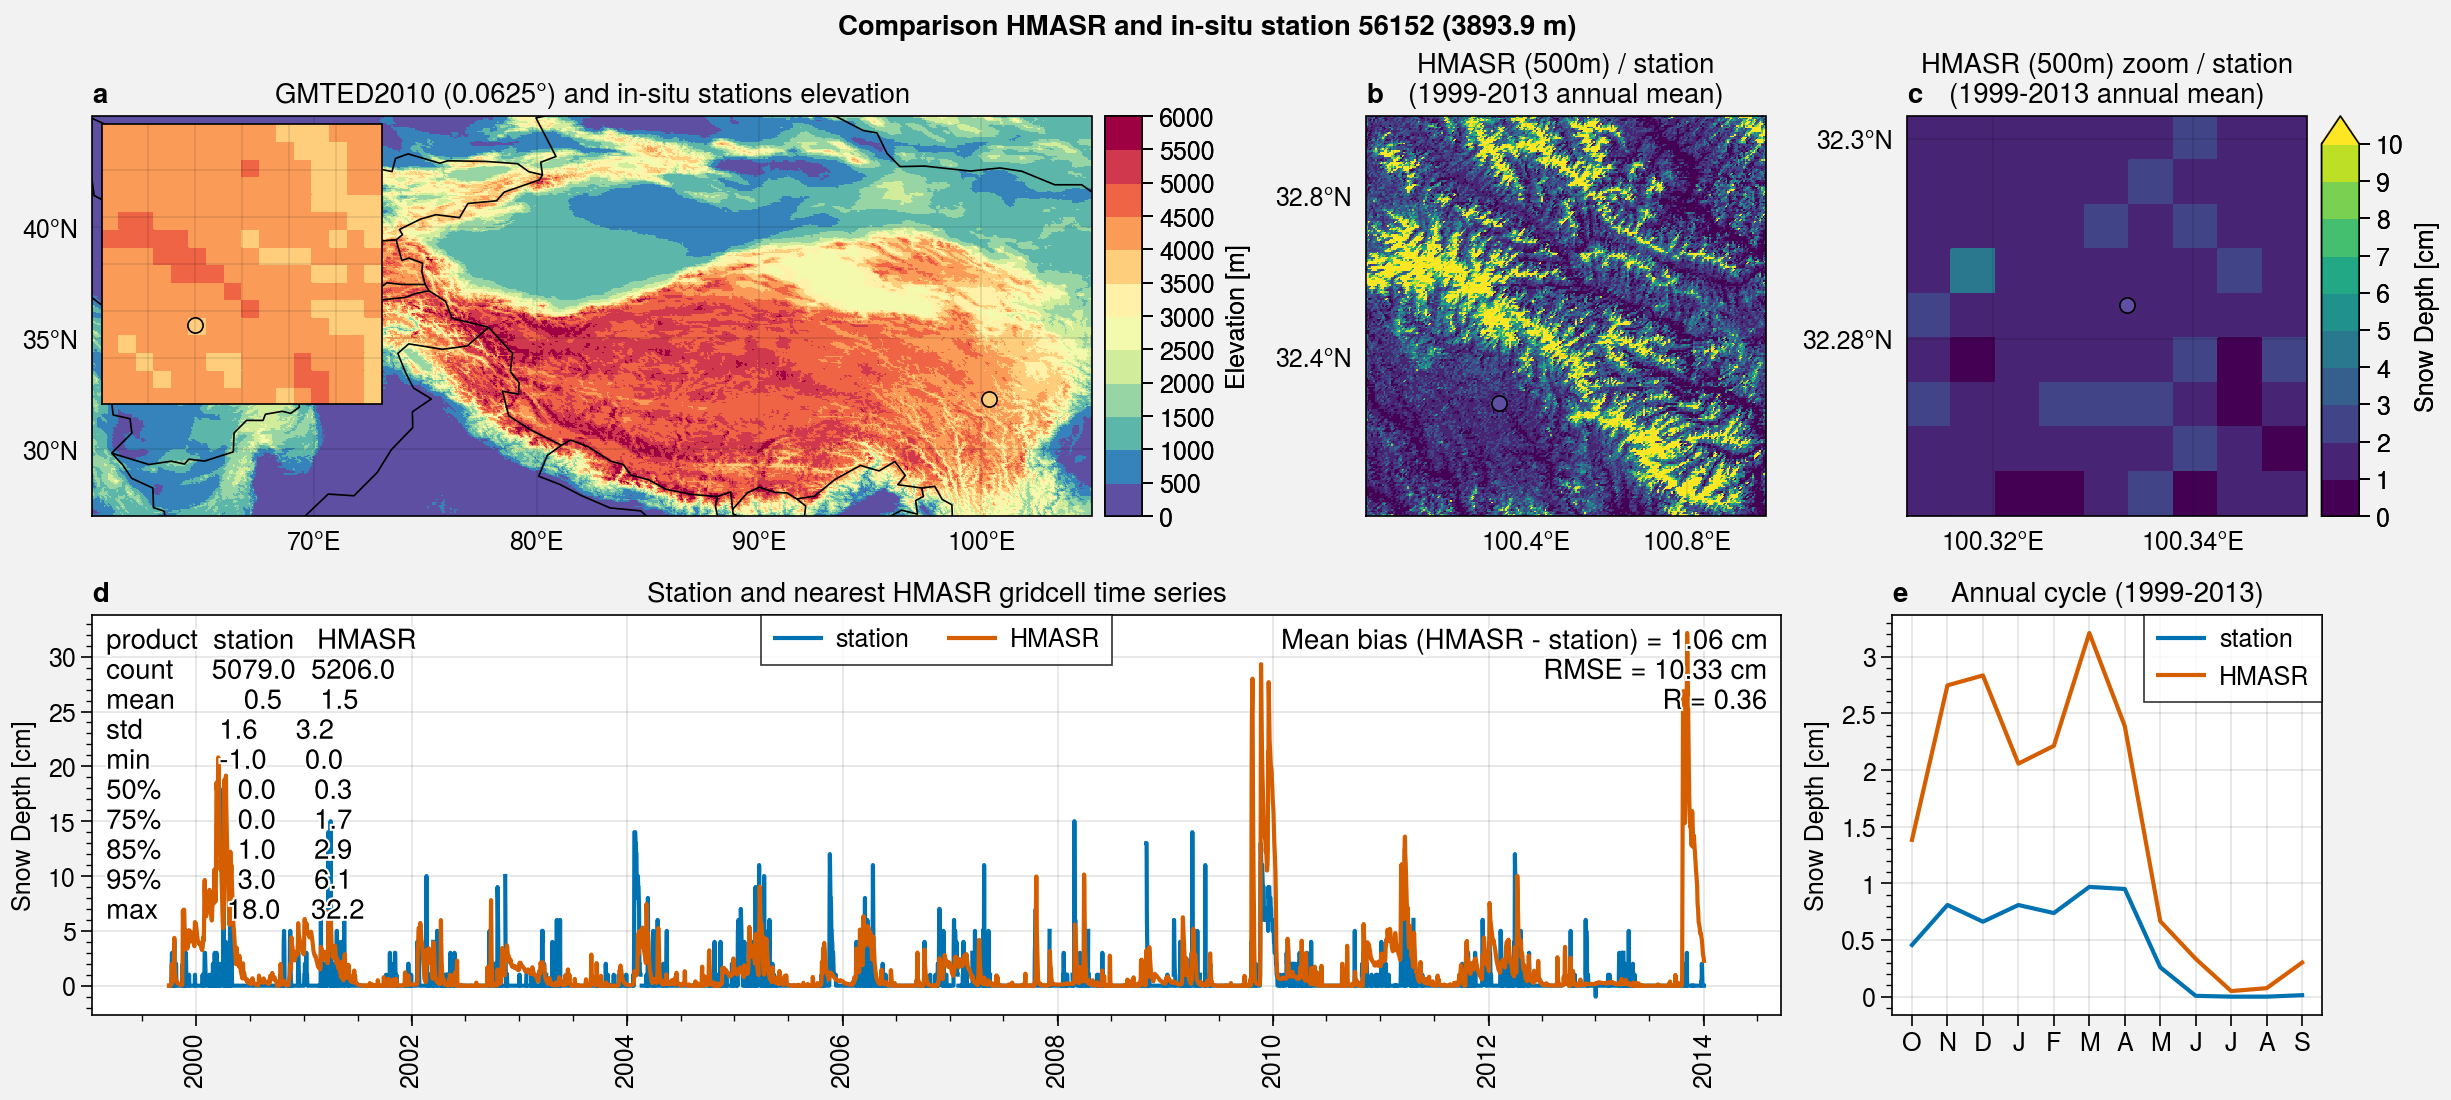

In [27]:
cmap='Spectral_r'
levels=plot.arange(0,6000,500)
markersize=30
pd.set_option("display.precision", 1)

fig, axs = plot.subplots([[1, 1, 2, 3], [4, 4, 4, 5]], proj=('cyl', 'cyl', 'cyl', None, None), axwidth=5, share=0)

# Plot topography (HMA + zoom)
axs[0].pcolormesh(elevation, colorbar='r', cmap=cmap, levels=levels, colorbar_kw={'label': 'Elevation [m]'})
axs[0].scatter(
    df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
    df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
    markersize=markersize, marker='o', color=df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values, 
    cmap=cmap, edgecolors='black', levels=levels
)

# Create inset axes representing a "zoom-in"
ix = axs[0].inset(
    [-0.2, 0.28, 0.7, 0.7], zoom=False, proj='cyl'
)
ix.pcolormesh(elevation, cmap=cmap, levels=levels)
ix.scatter(
    df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
    df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
    markersize=markersize, marker='o', color=df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values, 
    cmap=cmap, edgecolors='black', levels=levels
)
ix.format(
    latlim=(da.lat.min().values.item(0), da.lat.max().values.item(0)), 
    lonlim=(da.lon.min().values.item(0), da.lon.max().values.item(0)),
    borders=True
)
    
    
# Plot SD
levels_SD = plot.arange(0, 0.1, 0.01)*100
for i, ax in enumerate([axs[1], axs[2]]):
    if i == 0:
        ax.pcolormesh(da.mean('time')*100, cmap='viridis', levels=levels_SD, extend='max')
    else:
        ax.pcolormesh(da.mean('time')*100, colorbar='r', cmap='viridis', levels=levels_SD, extend='max', colorbar_kw={'label': 'Snow Depth [cm]'})
    ax.scatter(
        df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
        df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
        markersize=markersize, marker='o', color=df_all.iloc[:, i_station][:'2000-09-30'].mean(), 
        cmap=cmap, edgecolors='black', levels=levels_SD
    )

# Compute metrics
mb = (df_station_HMASR[df_all.iloc[:, i_station].name].dropna().mean().HMASR - df_station_HMASR[df_all.iloc[:, i_station].name].dropna().mean().station)
rmse = ((df_station_HMASR[df_all.iloc[:, i_station].name].dropna().HMASR - df_station_HMASR[df_all.iloc[:, i_station].name].dropna().station)**2).mean()
corr, _ = stats.pearsonr(
    df_station_HMASR[df_all.iloc[:, i_station].name].dropna().HMASR, 
    df_station_HMASR[df_all.iloc[:, i_station].name].dropna().station
)
    
# Time series
hs = axs[3].plot(df_station_HMASR[df_all.iloc[:, i_station].name])
# axs[3].plot(df_station_HMASR[df_all.iloc[:, i_station].name].HMASR, label='HMASR')
axs[3].format(
    ylabel='Snow Depth [cm]',
    ultitle=str(df_station_HMASR[df_all.iloc[:, i_station].name].describe(percentiles = [0.75, 0.85, 0.95])),
    urtitle='Mean bias (HMASR - station) = {:.2f}'.format(mb)+' cm\nRMSE = {:.2f}'.format(rmse)+' cm\nR = {:.2f}'.format(corr)
)
axs[3].legend(hs, loc='uc')


# Annual cycle
ac = df_station_HMASR[df_all.iloc[:, i_station].name].groupby(df_station_HMASR.index.month).mean()
h1 = axs[4].plot(ac.reindex(index=np.roll(ac.index,3)).station.values, label='station')
h2 = axs[4].plot(ac.reindex(index=np.roll(ac.index,3)).HMASR.values, label='HMASR')
axs[4].format(
    xlocator='index', xformatter=['O','N','D', 'J','F','M','A','M','J','J','A','S'], xtickminor=False, xlabel='',
)
hs = [h1, h2]
axs[4].legend(hs, ncol=1)
axs[4].format(ylabel='Snow Depth [cm]')


    
# Format   
axs.format(
    suptitle='Comparison HMASR and in-situ station '+str(df_all.iloc[:, i_station].name)+ \
    ' ('+str(df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values.item(0))+' m)',
    abc=True
)

axs[0].format(
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)

axs[1].format(
    latlim=(da.lat.min().values.item(0), da.lat.max().values.item(0)), 
    lonlim=(da.lon.min().values.item(0), da.lon.max().values.item(0)),
    lonlines=0.4, latlines=0.4, borders=True, labels=True,
)
    
axs[2].format(
    latlim=(da_station.lat.values.item(0)-0.02, da_station.lat.values.item(0)+0.02), 
    lonlim=(da_station.lon.values.item(0)-0.02, da_station.lon.values.item(0)+0.02),
    lonlines=0.02, latlines=0.02, borders=True, labels=True,
)


titles = [
    'GMTED2010 (0.0625°) and in-situ stations elevation',
    'HMASR (500m) / station\n(1999-2013 annual mean)', 'HMASR (500m) zoom / station\n(1999-2013 annual mean)',
    'Station and nearest HMASR gridcell time series', 'Annual cycle (1999-2013)'
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i])

# fig.save('img/comparison_HMASR_station_'+str(df_all.iloc[:, i_station].name)+'.jpg')

### Make loop for all stations

In [9]:

i_station = 85
lat = df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0]
lon = df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0]

list_da = []
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2014))]

for WY in WY_list:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'

    temp = xr.open_dataarray(path+'HMA_SR_D_v01_N'+str(int(lat))+'_0E'+str(int(lon))+'_0_agg_16_'+WY+'_SD_POST.nc').isel(Stats=0)
    temp = temp.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=temp.Day.size, freq='D'))
    temp = temp.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
    list_da.append(temp.sel(time=slice(df_all.index[0], df_all.index[-1])).load())
    
da = xr.concat(list_da, 'time')
da_station = da.sel(lat=lat, lon=lon, method='nearest').load()

df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'station')] = df_all.iloc[:, i_station]
df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'HMASR')] = da_station*100

WY1999_00
WY2000_01
WY2001_02
WY2002_03
WY2003_04
WY2004_05
WY2005_06
WY2006_07
WY2007_08
WY2008_09
WY2009_10
WY2010_11
WY2011_12
WY2012_13
WY2013_14


In [72]:
for i_station in range(0, df_loc.index.size):
    
    if i in [73, 101]: continue # HMASR not defined for this station
    
    print('i_station: '+str(i_station))
    print('numb: '+str(df_all.iloc[:, i_station].name))
    print('')

    lat = df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0]
    lon = df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0]

    list_da = []
    WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2014))]

    for WY in WY_list:
        print(WY)
        path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'

        temp = xr.open_dataarray(path+'HMA_SR_D_v01_N'+str(int(lat))+'_0E'+str(int(lon))+'_0_agg_16_'+WY+'_SD_POST.nc').isel(Stats=0)
        temp = temp.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=temp.Day.size, freq='D'))
        temp = temp.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
        list_da.append(temp.sel(time=slice(df_all.index[0], df_all.index[-1])).load())

    da = xr.concat(list_da, 'time')
    da_station = da.sel(lat=lat, lon=lon, method='nearest').load()

    df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'station')] = df_all.iloc[:, i_station]
    df_station_HMASR.loc[:, (df_all.iloc[:, i_station].name, 'HMASR')] = da_station*100

    ###################
    ### Make figure ###
    ###################
    
    cmap='Spectral_r'
    levels=plot.arange(0,6000,500)
    markersize=30
    pd.set_option("display.precision", 1)

    fig, axs = plot.subplots([[1, 1, 2, 3], [4, 4, 4, 5]], proj=('cyl', 'cyl', 'cyl', None, None), axwidth=5, share=0)

    # Plot topography (HMA + zoom)
    axs[0].pcolormesh(elevation, colorbar='r', cmap=cmap, levels=levels, colorbar_kw={'label': 'Elevation [m]'})
    axs[0].scatter(
        df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
        df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
        markersize=markersize, marker='o', color=df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values, 
        cmap=cmap, edgecolors='black', levels=levels
    )

    # Create inset axes representing a "zoom-in"
    ix = axs[0].inset(
        [-0.2, 0.28, 0.7, 0.7], zoom=False, proj='cyl'
    )
    ix.pcolormesh(elevation, cmap=cmap, levels=levels)
    ix.scatter(
        df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
        df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
        markersize=markersize, marker='o', color=df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values, 
        cmap=cmap, edgecolors='black', levels=levels
    )
    ix.format(
        latlim=(da.lat.min().values.item(0), da.lat.max().values.item(0)), 
        lonlim=(da.lon.min().values.item(0), da.lon.max().values.item(0)),
        borders=True
    )


    # Plot SD
    levels_SD = plot.arange(0, 0.1, 0.01)*100
    for i, ax in enumerate([axs[1], axs[2]]):
        if i == 0:
            ax.pcolormesh(da.mean('time')*100, cmap='viridis', levels=levels_SD, extend='max')
        else:
            ax.pcolormesh(da.mean('time')*100, colorbar='r', cmap='viridis', levels=levels_SD, extend='max', colorbar_kw={'label': 'Snow Depth [cm]'})
        ax.scatter(
            df_loc.loc[[df_all.iloc[:, i_station].name]].longit.values[0], 
            df_loc.loc[[df_all.iloc[:, i_station].name]].latit.values[0], 
            markersize=markersize, marker='o', color=df_all.iloc[:, i_station][:'2000-09-30'].mean(), 
            cmap=cmap, edgecolors='black', levels=levels_SD
        )

    # Compute metrics
    mb = (df_station_HMASR[df_all.iloc[:, i_station].name].dropna().mean().HMASR - df_station_HMASR[df_all.iloc[:, i_station].name].dropna().mean().station)
    rmse = ((df_station_HMASR[df_all.iloc[:, i_station].name].dropna().HMASR - df_station_HMASR[df_all.iloc[:, i_station].name].dropna().station)**2).mean()
    corr, _ = stats.pearsonr(
        df_station_HMASR[df_all.iloc[:, i_station].name].dropna().HMASR, 
        df_station_HMASR[df_all.iloc[:, i_station].name].dropna().station
    )

    # Time series
    hs = axs[3].plot(df_station_HMASR[df_all.iloc[:, i_station].name])
    # axs[3].plot(df_station_HMASR[df_all.iloc[:, i_station].name].HMASR, label='HMASR')
    axs[3].format(
        ylabel='Snow Depth [cm]',
        ultitle=str(df_station_HMASR[df_all.iloc[:, i_station].name].describe(percentiles = [0.75, 0.85, 0.95])),
        urtitle='Mean bias (HMASR - station) = {:.2f}'.format(mb)+' cm\nRMSE = {:.2f}'.format(rmse)+' cm\nR = {:.2f}'.format(corr)
    )
    axs[3].legend(hs, loc='uc')


    # Annual cycle
    ac = df_station_HMASR[df_all.iloc[:, i_station].name].groupby(df_station_HMASR.index.month).mean()
    h1 = axs[4].plot(ac.reindex(index=np.roll(ac.index,3)).station.values, label='station')
    h2 = axs[4].plot(ac.reindex(index=np.roll(ac.index,3)).HMASR.values, label='HMASR')
    axs[4].format(
        xlocator='index', xformatter=['O','N','D', 'J','F','M','A','M','J','J','A','S'], xtickminor=False, xlabel='',
    )
    hs = [h1, h2]
    axs[4].legend(hs, ncol=1)
    axs[4].format(ylabel='Snow Depth [cm]')



    # Format   
    axs.format(
        suptitle='Comparison HMASR and in-situ station '+str(df_all.iloc[:, i_station].name)+ \
        ' ('+str(df_loc.loc[[df_all.iloc[:, i_station].name]].elevat.values.item(0))+' m)',
        abc=True
    )

    axs[0].format(
        borders=True, labels=True, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    )

    axs[1].format(
        latlim=(da.lat.min().values.item(0), da.lat.max().values.item(0)), 
        lonlim=(da.lon.min().values.item(0), da.lon.max().values.item(0)),
        lonlines=0.4, latlines=0.4, borders=True, labels=True,
    )

    axs[2].format(
        latlim=(da_station.lat.values.item(0)-0.02, da_station.lat.values.item(0)+0.02), 
        lonlim=(da_station.lon.values.item(0)-0.02, da_station.lon.values.item(0)+0.02),
        lonlines=0.02, latlines=0.02, borders=True, labels=True,
    )


    titles = [
        'GMTED2010 (0.0625°) and in-situ stations elevation',
        'HMASR (500m) / station\n(1999-2013 annual mean)', 'HMASR (500m) zoom / station\n(1999-2013 annual mean)',
        'Station and nearest HMASR gridcell time series', 'Annual cycle (1999-2013)'
    ]
    for i, ax in enumerate(axs):
        ax.format(title=titles[i])
        
    print('')

    fig.save('img/comparison_HMASR_station_'+str(df_all.iloc[:, i_station].name)+'.jpg')

## Save timseries data 

In [ ]:
df_station_HMASR.